#Step 1: Dataset Selection and Exploration

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

train_df = pd.read_csv('sign_mnist_train.csv')   # read from the training dataset and convert to dataframe
test_df = pd.read_csv('sign_mnist_test.csv')     # read from the test dataset and convert to dataframe

# print dimensions of the datasets
# print('Training shape:', train_df.shape)
# print('Testing shape :', test_df.shape)

X_train = train_df.drop(columns=['label']).values
X_test = test_df.drop(columns=['label']).values

y_train = train_df['label'].values
y_test = test_df['label'].values

# Preprocess the data
X_train = X_train.reshape(-1, 28, 28, 1) / 255.0  # Reshape to (28, 28, 1) and normalize
X_test = X_test.reshape(-1, 28, 28, 1) / 255.0    # Reshape to (28, 28, 1) and normalize

In [ ]:
train_df.head()  # get first 5 rows of training set

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


Image dimensions: 28 x 28 x 1
Number of classes: 24
Label map: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y'}
Total number of images: 27455
Average number of images per label: 1143.9583333333333


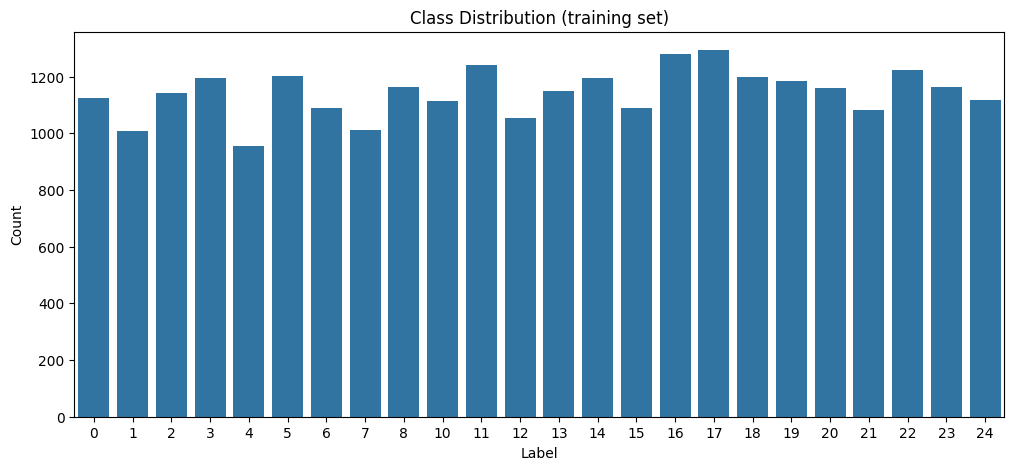

In [ ]:
print(f'Image dimensions: 28 x 28 x 1') # image dimensions

# classes and names
num_classes = len(np.unique(y_train))
label_map = {}
ascii_val = 65
for i in sorted(np.unique(y_train)):
  if ascii_val == 74:   # if curr ascii is 74 = 'J', skip it
    ascii_val += 1
  label_map[int(i)] = chr(ascii_val)
  ascii_val += 1

print('Number of classes:', num_classes)
print('Label map:', label_map)

class_counts = pd.Series(y_train).value_counts().sort_index()
# print('\nClass counts (label : count):')
# print(class_counts.to_string())

# stats for the training data set
print(f"Total number of images: {class_counts.sum()}")
print(f"Average number of images per label: {class_counts.mean()}")

# class distribution histogram
plt.figure(figsize=(12,5))
sns.countplot(x=y_train)
plt.title('Class Distribution (training set)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

#Step 2: CNN Model Design + Step 3: Training and Evaluation

In [ ]:
# Convert labels to categorical (one-hot encoding)
y_train = to_categorical(y_train, 25)
y_test = to_categorical(y_test, 25)

# define a function to create and train a CNN model with custom hyperparameters and display results
def train_and_display_cnn(filters=32, kernel_size=(3,3), pool_size=(2,2), epochs=5, experiment_name="Experiment"):

  global X_train, X_test, y_train, y_test

  # Make local copies so we don't overwrite global variables by accident
  X_train_local = X_train
  X_test_local  = X_test
  y_train_local = y_train
  y_test_local  = y_test

  # Create CNN model
  model = Sequential([
      Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same', input_shape=(28,28,1)),
      Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', padding='same'),
      MaxPooling2D(pool_size=pool_size),
      Dropout(0.25), # reduce overfitting

      Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same'),
      Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu', padding='same'),
      MaxPooling2D(pool_size=pool_size),
      Dropout(0.25),

      Flatten(),
      Dense(128, activation='relu'),
      Dropout(0.5),
      Dense(25, activation='softmax')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Start timer for training
  start_time = time.time()


  # if labels are integers (1-D), convert them to one-hot
  if y_train.ndim == 1:
    y_train = to_categorical(y_train, num_classes=25)
  if y_test.ndim == 1:
    y_test = to_categorical(y_test, num_classes=25)

  # Train the model
  history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0)

  # Calculate training time
  training_time = time.time() - start_time

  # Evaluate the model
  test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

  # Generate predictions for confusion matrix
  y_pred = np.argmax(model.predict(X_test), axis=1)
  y_true = np.argmax(y_test, axis=1)

  # Generate confusion matrix
  conf_matrix = confusion_matrix(y_true, y_pred)
  class_report = classification_report(y_true, y_pred)

  # sisplay results
  print(f"\n--- {experiment_name} ---")
  print(f"Training Time: {training_time:.2f} seconds")
  print(f"Test Accuracy: {test_acc:.4f}")
  print("Confusion Matrix:")
  print(conf_matrix)
  print("\nClassification Report:")
  print(class_report)

#Step 3: Experiment and Improve

###Experiment 1: Default Settings (32 filters, 3x3 kernel, 2x2 pool size)

In [ ]:
train_and_display_cnn(filters=32, kernel_size=(3,3), pool_size=(2,2), epochs=5, experiment_name="Experiment 1: Default (32 filters, 3x3 kernel, 2x2 pool)")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- Experiment 1: Default (32 filters, 3x3 kernel, 2x2 pool) ---
Training Time: 28.35 seconds
Test Accuracy: 0.9555
Confusion Matrix:
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 431   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 470   0   0   0   0   0   0   0   0   0   0   0   0  28
    0   0   0   0   0   0]
 [  0   0   0   0   0 247   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 346   2   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0  28 407   0   0   0   0   0   0   0   0   0   0
    1   0   0   0   0   0]
 [  0   0   0   

###Experiment 2: Double the filters (64 filters, 3x3 kernel, 2x2 pool size)

In [ ]:
train_and_display_cnn(filters=64, kernel_size=(3,3), pool_size=(2,2), epochs=5, experiment_name="Experiment 2: Double the filters (64 filters, 3x3 kernel, 2x2 pool)")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- Experiment 2: Double the filters (64 filters, 3x3 kernel, 2x2 pool) ---
Training Time: 37.53 seconds
Test Accuracy: 0.9654
Confusion Matrix:
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 416   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0  16   0   0   0   0]
 [  0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 498   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 247   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 348   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0  20 416   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0

###Experiment 3: Double the epochs (32 filters, 3x3 kernel, 2x2 pool size)

In [ ]:
train_and_display_cnn(filters=32, kernel_size=(3,3), pool_size=(2,2), epochs=10, experiment_name="Experiment 3: Double the epochs (32 filters, 3x3 kernel, 2x2 pool)")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- Experiment 3: Double the epochs (32 filters, 3x3 kernel, 2x2 pool) ---
Training Time: 48.97 seconds
Test Accuracy: 0.9681
Confusion Matrix:
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 411   0   0   0   0   0   0   0  21   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 493   0   0   0   0   0   0   0   0   0   0   0   0   5
    0   0   0   0   0   0]
 [  0   0   0   0   0 247   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   4   0   0   0 308   0   0   0   0   0   0   0   0   0   0   0
   36   0   0   0   0   0]
 [  0   0   0   0   0   0  20 416   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 

###Experiment 4: Larger Kernel Size (32 filters, 4x4 kernel, 2x2 pool size)

In [ ]:
train_and_display_cnn(filters=32, kernel_size=(4,4), pool_size=(2,2), epochs=5, experiment_name="Experiment 4: Larger Kernel Size (32 filters, 4x4 kernel, 2x2 pool)")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- Experiment 4: Larger Kernel Size (32 filters, 4x4 kernel, 2x2 pool) ---
Training Time: 32.81 seconds
Test Accuracy: 0.9642
Confusion Matrix:
[[310   0   0   0   0   0   0   0   0   0   0   0  21   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 421   0   0   0   0   0   0   0   8   0   0   0   0   0   0   0   0
    0   3   0   0   0   0]
 [  0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 245   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 496   0   0   0   0   0   0   0   0   0   0   0   0   2
    0   0   0   0   0   0]
 [  0   0   0   0   0 247   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 327   0   0   0   0   0   0   0   0   0   2   0
   19   0   0   0   0   0]
 [  0   0   0   0   0   0  20 416   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0

###Experiment 5: Larger Pool Size (32 filters, 3x3 kernel, 3x3 pool size)

In [ ]:
train_and_display_cnn(filters=32, kernel_size=(3,3), pool_size=(3,3), epochs=5, experiment_name="Experiment 5: Larger Pool Size (32 filters, 3x3 kernel, 3x3 pool)")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

--- Experiment 5: Larger Pool Size (32 filters, 3x3 kernel, 3x3 pool) ---
Training Time: 27.56 seconds
Test Accuracy: 0.9805
Confusion Matrix:
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 411   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0  21   0   0]
 [  0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 224   0   0   0   0   0   0   0   0   0   0   0   0  21   0
    0   0   0   0   0   0]
 [  0   0   0   0 496   0   0   0   0   0   0   0   0   0   0   0   0   2
    0   0   0   0   0   0]
 [  0   0   0   0   0 247   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 323  25   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0   5 431   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0  

###Experiment 6: Larger Kernel and Pool Size, Double the Epochs (32 filters, 5x5 kernel, 3x3 pool size)

In [ ]:
train_and_display_cnn(filters=32, kernel_size=(3,3), pool_size=(3,3), epochs=10, experiment_name="Experiment 6: Larger Kernel and Pool Size, Double the Epochs (32 filters, 5x5 kernel, 3x3 pool")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- Experiment 6: Larger Kernel and Pool Size, Double the Epochs (32 filters, 5x5 kernel, 3x3 pool ---
Training Time: 44.15 seconds
Test Accuracy: 0.9788
Confusion Matrix:
[[331   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0 431   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0 310   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0 231  14   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0 498   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0 247   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0]
 [  0   0   0   0   0   0 323   8   0   0   0   0   0   0   4   0   0   0
   13   0   0   0   0   0]
 [  0   0   0   0   0   0   0 436   0   0   0   0   0   0   0   0   0   0
    0

Dataset Overview:
- The MNIST Sign-Language dataset has grayscale images (28x28), and 24 classes (A-Y excluding J and Z). J and Z signs were excluded because they require motions of the hand (videos/GIFs) and are not static images which are not being passed as an input to the CNN. The dataset has 27,445 total training images and 7172 test images. There are about 1144 images for each class on average for the training set.


CNN Architecture:
- The CNN model was designed to progressively learn features from the 28x28 grayscale images efficiently. It has two convolutional blocks where each has a max-pooling layer to reduce dimensions and a dropout layer to reduce overfitting by randomly disabling neurons while training so their learned weight goes to 0. ReLU was used as the activation function so that the model could learn non-linear patterns. We then flatten the resulting feature maps into a 1D vector which can be passed to a normal neural network. There is a final softmax function applied to the last layer to get the output probabilities for each of the classes.


Accuracy/loss plots:
- Most of the runs got an accuracy of about 95-98%. There were some errors that I believe can be fixed if given more computational resources and layers.


Final test results:
- Most of the runs had decent performance. The best run was Experiment 5, with larger pooling size.


Reflection:
What types of patterns did your CNN learn?
- The CNN learnt low-level patterns like edges or outlines of the hand and fingers, curves, edges, etc and high-level patterns like the arrangement of fingers and palms that sign different letters. These kinds of spatial patterns is what CNNs are great at extracting from these grayscale images.

What were the most common misclassifications?
- The most common misclassifications I saw were H as G, K as R, N as A and U, and Y as X and V.

What were your most important design trade-offs?
- Complexity - The model only has 2 layers to cut down computational costs, but still provides a decent accuracy rate of 96%.
- Dropouts - This reduces overfitting but slows down learning. It balances generalization well though.
- Kernel and pooling sizes - using smaller sizes minimizes the number of parameters and makes computing faster but can be made more accurate by increasing it.

How would you improve your model with more time, compute, or data?
So far, the best experiment I ran was with an increase in pool size. We can improve the model performance by:
- Adding more convolutional layers would make the model recognize even more hidden patterns.
- If there was more data and time, we could train the CNN on a larger dataset, making it learn better.
- We could add support for J and Z if we could extend the CNN to be able to learn motions from videos instead of just static images.
